In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from scipy.stats import beta

**Goal:** improve the world's best estimate of the area of the Mandelbrot set.

The [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set) is a set of [complex numbers](https://en.wikipedia.org/wiki/Complex_number) $c$ for which

$$z_{i + 1} = |z_i|^2 + c \mbox{ with } z_0 = 0$$

does not diverge to infinity. That is, the set $c$ for which $|z_i| \to \infty$ as $i \to \infty$. Sequences $z_i$ that cycle or converge to any finite point are considered in the set; anything else is outside the set.

The following function identifies whether a _point_ $c = x + y i$ is in the Mandelbrot set or not ($x$ and $y$ are real numbers and $i = \sqrt{-1}$). It uses 32-bit (single precision) floating point to approximate real numbers (`np.complex64` is made of two `np.float32`). The algorithm tracks $z_i$ for two consecutive $i$, named "tortoise" and "hare" because [the hare is ahead of the tortoise](https://en.wikipedia.org/wiki/The_Tortoise_and_the_Hare) by a factor of 2. This is [Floyd's algorithm](https://en.wikipedia.org/wiki/Cycle_detection#Floyd%27s_tortoise_and_hare) for detecting cycles in a sequence (including the "cycle" of converging to a point).

In [2]:
@nb.jit
def is_in_mandelbrot(x, y):
    c = np.complex64(x) + np.complex64(y)*np.complex64(1j)
    z_hare = z_tortoise = np.complex64(0)
    while True:
        z_hare = z_hare*z_hare + c
        z_hare = z_hare*z_hare + c
        z_tortoise = z_tortoise*z_tortoise + c
        if z_hare == z_tortoise:
            return True      # orbiting or converging to zero
        if z_hare.real**2 + z_hare.imag**2 > 4:
            return False     # diverging to infinity

There's a mathematical theorem ([Knill (2023)](https://doi.org/10.48550/arXiv.2305.17848), section 4.7) that proves that the Mandelbrot set is entirely contained within $x \in (-2, 1)$, $y \in (-\frac{3}{2}, \frac{3}{2})$.

If $|z_i|^2 > 4$, then the $z_{i+1}$ with the smallest magnitude in that box is at $c = -2 + 0 i$, and that $z_{i+1} > 2$, which also has magnitude greater than $4$, so if a sequence ever exceeds $|z_i|^2 > 4$, then it diverges to infinity.

Let's take a look at it.

In [3]:
@nb.jit(parallel=True)
def draw_mandelbrot(num_x, num_y):
    xmin, xmax = -2, 1
    ymin, ymax = -3/2, 3/2
    
    pixels = np.empty((num_x, num_y), np.int32)
    dx = (xmax - xmin) / num_x
    dy = (ymax - ymin) / num_y
    
    for i in nb.prange(num_x):
        for j in nb.prange(num_y):
            x = xmin + i*dx
            y = ymin + j*dy
            pixels[j, i] = is_in_mandelbrot(x, y)

    return pixels

In [4]:
pixels = draw_mandelbrot(1000, 1000)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


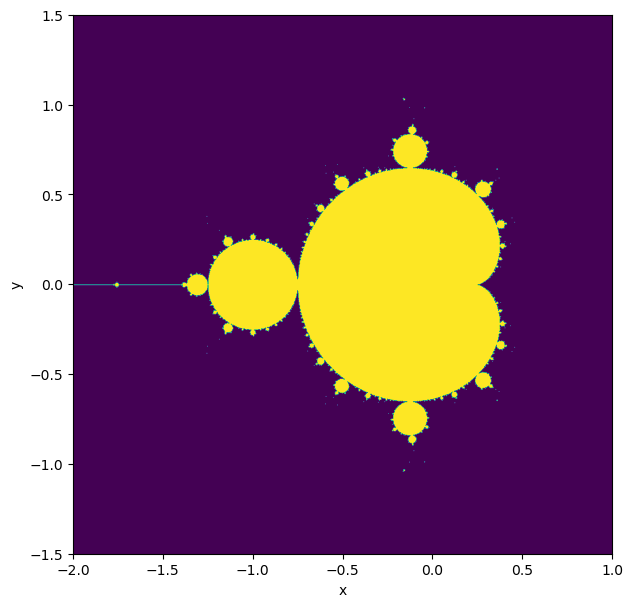

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(pixels, extent=[-2, 1, -3/2, 3/2])
ax.set_xlabel("x")
ax.set_ylabel("y")

None

The exact area of the Mandelbrot set is not known, mathematically. There is an expression,

$$\mbox{area of Mandelbrot set} = \pi \left( 1 - \sum_{n=1}^\infty n \, {b_n}^2 \right)$$

in which the terms $b_n$ can be determined recursively, but it converges very slowly: $10^{118}$ terms are needed to get the first 2 digits, and $10^{1181}$ terms are needed to get 3 digits ([Ewing & Schober (1992)](https://doi.org/10.1007/BF01385497)). The best estimates of the Mandelbrot set's area come from sampling techniques. The most recent publication is [Bittner, Cheong, Gates, & Nguyen (2012)](https://doi.org/10.2140/involve.2017.10.555) and the most recent unpublished estimate is [Förstemann (2017)](https://www.foerstemann.name/labor.html) using two Radeon HD 5970 GPUs. The most precise, rigorous bounds to date are

$$1.50640 < \mbox{area of Mandelbrot set} < 1.53121\mbox{.}$$

(If you're interested in this sort of thing, Robert Munafo wrote a [rabbit warren of hyperlinked pages](http://www.mrob.com/pub/muency/areaofthemandelbrotset.html) about all of the techniques in 2003, from a [Usenet thread (alt.fractals)](https://ics.uci.edu/~eppstein/junkyard/mand-area.html) that started exactly 5 days after the [first release of Python (alt.sources)](https://www.tuhs.org/Usenet/alt.sources/1991-February/001749.html). Weird coincidence, huh?)

The goal of this project is to estimate the area of the Mandelbrot set by sampling, _maybe improving upon the world's best estimate._

In [6]:
@nb.jit
def count_mandelbrot(rng, num_samples, xmin, width, ymin, height):
    out = np.int32(0)
    for x_norm, y_norm in rng.random((num_samples, 2), np.float32):
        x = xmin + (x_norm * width)
        y = ymin + (y_norm * height)
        out += is_in_mandelbrot(x, y)
    return out

In [7]:
xmin, xmax = -2, 1
ymin, ymax = -3/2, 3/2

rng = np.random.default_rng()   # can be forked to run multiple rngs in parallel

denominator = 100000
numerator = count_mandelbrot(rng, denominator, xmin, xmax - xmin, ymin, ymax - ymin)

area = (numerator / denominator) * (xmax - xmin) * (ymax - ymin)
area

1.51443

Just like an experimental measurement, sampling introduces uncertainty. To the (very high) degree that our generated random numbers are independent, sampling an area and asking which points are in the Mandelbrot set are [Bernoulli trials](https://en.wikipedia.org/wiki/Bernoulli_trial), and we can use the (conservative but exact) [Clopper-Pearson interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval) to quantify the uncertainty.

In the following, there is a 95% probability that the true Mandelbrot area is between `low` and `high`:

In [8]:
def confidence_interval(confidence_level, numerator, denominator, area):
    low, high = beta.ppf(
        [confidence_level/2, 1 - confidence_level/2],
        [numerator, numerator + 1],
        [denominator - numerator + 1, denominator - numerator]
    ) * area

    low = np.nan_to_num(np.asarray(low), nan=0)
    high = np.nan_to_num(np.asarray(high), nan=area)

    return low, high

In [9]:
confidence_interval(0.05, numerator, denominator, (xmax - xmin) * (ymax - ymin))

(np.float64(1.4936035979348152), np.float64(1.535429716688143))

We can reduce this interval by increasing `num_samples`, but look at the plot: there are regions of fine detail and regions that are almost entirely inside or outside of the set. Samples in different geographic regions make wildly different contributions to the uncertainty in the final result.

In [10]:
region1 = {"xmin": -1.5, "ymin": 0.5, "width": 0.5, "height": 0.5}
region2 = {"xmin": -0.4, "ymin": 0.5, "width": 0.5, "height": 0.5}
region3 = {"xmin": -0.4, "ymin": -0.25, "width": 0.5, "height": 0.5}

for region in [region1, region2, region3]:
    denominator = 10000
    numerator = count_mandelbrot(rng, denominator, region["xmin"], region["width"], region["ymin"], region["height"])

    low, high = confidence_interval(0.05, numerator, denominator, region["width"] * region["height"])

    print(f"{numerator:5d}/{denominator}  -->  low: {low:8.3g}, high: {high:8.3g}  -->  uncertainty: {high - low:8.3g}")

    0/10000  -->  low:        0, high: 9.22e-05  -->  uncertainty: 9.22e-05
 4009/10000  -->  low:   0.0978, high:    0.103  -->  uncertainty:  0.00483
10000/10000  -->  low:     0.25, high:     0.25  -->  uncertainty: 9.22e-05


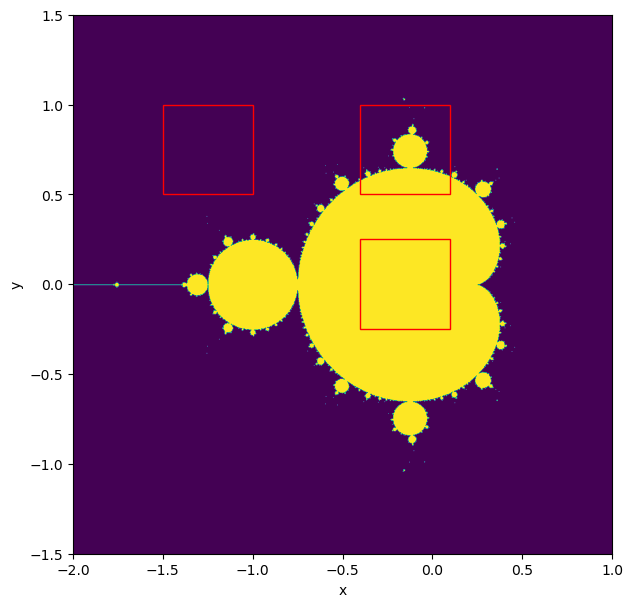

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(pixels, extent=[-2, 1, -3/2, 3/2])
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.add_patch(matplotlib.patches.Rectangle((-1.5, 0.5), 0.5, 0.5, edgecolor="red", facecolor="none"))
ax.add_patch(matplotlib.patches.Rectangle((-0.4, 0.5), 0.5, 0.5, edgecolor="red", facecolor="none"))
ax.add_patch(matplotlib.patches.Rectangle((-0.4, -0.25), 0.5, 0.5, edgecolor="red", facecolor="none"))

None

To get the most precision per time spent computing, let's split the area into a grid, sample each cell in the grid, and subdivide grid cells that have the most area uncertainty.

Grid cells that straddle the rough (fractal) edge of the Mandelbrot set have the highest uncertainty because the numerator is both far from zero and far from the denominator. But grid cells far from the boundary have non-zero uncertainty, since the Clopper-Pearson interval is not zero at these extremes. Thus, the possibility that the sampling of a cell simply missed a long, thin dendrite will eventually get explored, but only after larger contributions to the uncertainty have been explored.

To perform this adaptive sampling, we make arrays to describe the grid (`xmin`, `ymin`, `width`, `height`) and arrays to contain outputs (`numerators`, `uncertainty`). The first element (`0`) of these arrays represents the sampling of the whole $x \in (-2, 1)$, $y \in (-\frac{3}{2}, \frac{3}{2})$ region. Each sequential step selects the cell with the highest `uncertainty`, subdivides it by `split_factor` on each side (one cell is replaced by `split_factor**2` cells) and samples each of the new cells. The old cell is invalidated by setting

```python
uncertainty[i_to_split] = 0
```

so that the active cells (with non-zero `uncertainty`) completely cover the region without overlaps. Each is a statistically independent measurement of a non-overlapping tile of the complex plane. When we've run out of places to put the output, we stop.

In [12]:
rng = np.random.default_rng()   # can be forked to run multiple rngs in parallel

confidence_level = 0.05
split_factor = 4
num_cells = 10000

xmin = np.full(num_cells, np.nan, np.float32)
ymin = np.full(num_cells, np.nan, np.float32)
width = np.full(num_cells, np.nan, np.float32)
height = np.full(num_cells, np.nan, np.float32)

denominator = 1000
numerators = np.full(num_cells, 0, np.int32)
uncertainty = np.full(num_cells, 0, np.float32)

def fill_arrays(i):
    numerators[i] = count_mandelbrot(rng, denominator, xmin[i], width[i], ymin[i], height[i])
    low, high = confidence_interval(confidence_level, numerators[i], denominator, width[i] * height[i])
    uncertainty[i] = high - low

width[0] = 3
height[0] = 3
xmin[0] = -2
ymin[0] = -3/2

i_next = 0

fill_arrays(i_next)
i_next += 1

while i_next + split_factor**2 < num_cells:
    i_to_split = np.argmax(uncertainty)

    for i in range(split_factor):
        for j in range(split_factor):
            width[i_next] = width[i_to_split] / split_factor
            height[i_next] = height[i_to_split] / split_factor
            xmin[i_next] = xmin[i_to_split] + (i * width[i_next])
            ymin[i_next] = ymin[i_to_split] + (j * height[i_next])

            fill_arrays(i_next)
            i_next += 1

    uncertainty[i_to_split] = 0

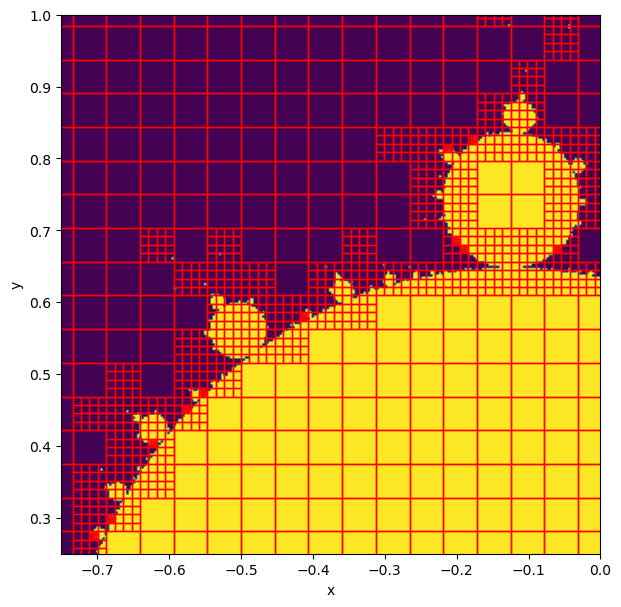

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(pixels, extent=[-2, 1, -3/2, 3/2])
ax.set_xlabel("x")
ax.set_ylabel("y")

for i in range(num_cells):
    if uncertainty[i] != 0:
        ax.add_patch(
            matplotlib.patches.Rectangle(
                (xmin[i], ymin[i]), width[i], height[i], edgecolor="red", facecolor="none"
            )
        )

ax.set_xlim(-0.75, 0)
ax.set_ylim(0.25, 1)

None

Since each of the active (`uncertainty[i] != 0`) cells contain statistically independent measurements of non-overlapping tiles that completely fill the original region, the total area is the `numerators[i] / denominator` of each cell, scaled by the area of the cell:

In [14]:
total_area = 0

for i in range(num_cells):
    if uncertainty[i] != 0:
        total_area += numerators[i] / denominator * width[i] * height[i]

float(total_area)

1.506516654968265

[Förstemann (2012)'s result](https://www.foerstemann.name/labor.html) (current world's best) is 1.50659.

Now we'd like to compute a confidence interval on this final central value, but it's not clear to me how to do it. We have individual numerators and denominators for each (statistically independent, non-overlapping, space-filling) cells, but each square cell has a different area, so the numerator, denominator pairs in each bin must be weighted by their areas.

I was talking with Nick Smith about this, and it's exactly the same problem as computing a confidence interval for an observable sampled by different Monte Carlo samples that have been generated with different effective integrated luminosities. He said that this is called Barlow-Beeston Lite in CMS Combine and Conway's approximation in other contexts.

* Conway's paper: https://cds.cern.ch/record/1333496
* Hans Dembinski's paper: https://arxiv.org/abs/2206.12346

Both of these involve doing a non-linear fit with as many free parameters as we have bins. I don't fully understand what's being computed here.

If anyone can help identify what we ought to compute to put a final confidence interval on this non-uniformly sampled integral, please help!